In [1]:
from IPython.display import HTML

hide_me = ''
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')


# 1) Goals:

Determine the cause of the bizarre calibration output. 
- Time varying $\alpha$
- $C(t)$ that crosses zero
- $\gamma$ that is about half of what it should be
- Sawtooth pattern
- Within the warm bath spatial gradient in temperature


## Try:  
- $\overline{\alpha(t)}$, use mean value instead of time varying
- Sub-section of warm bath for calibration (e.g., after break)
- Look into sawtooth error

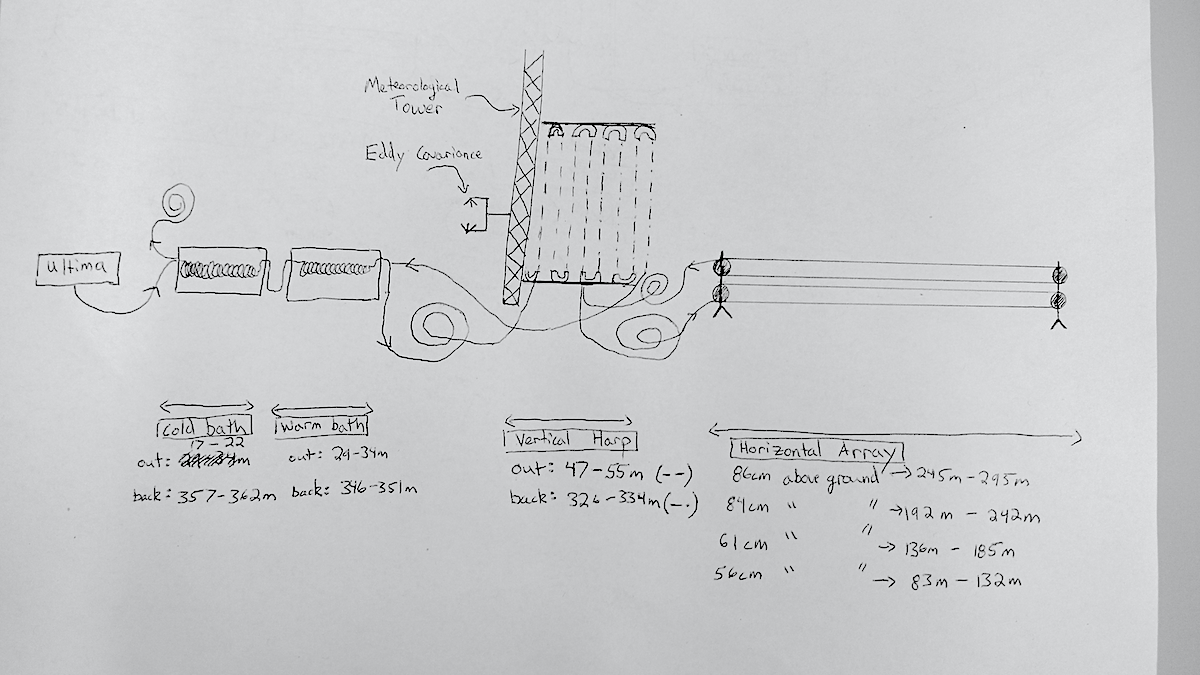

In [2]:
from IPython.core.display import Image 
Image(filename='/Users/karllapo/Desktop/proj/VertHarpExp2017Kloendeel/python/DTS/VertHarp.ExpDesign.jpg')


#### Sketch of the experimental set-up.
The Ultima is sampling a ~400m length of cable in a single-ended configuration. The cable runs runs out and then back, where it rests on the spool.
- On both the out and back the cable runs through a cold bath (which given our lack of ice is more of an ambient temperature bath) and a warm bath (~40C).
- On the tower we set up a vertical array of fiber optic cable to allow us to directly compare the eddy-covariance- and Ultima-derived temperatures. 
- We then run the cable out on a horizontal array, largely just to eat up cable before running the cable back to the vertical harp. 
- The main goal was to acquire a "near-Ultima" and "further-away-from-Ultima" comparison to understand how signal attenuation affects the spectral response of temperature observations.

In [3]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys
import pickle
import os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

# XML
import xmltodict

In [4]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists

# Find host name
import socket
if socket.gethostname().find('.')>=0:
    name=socket.gethostname()
else:
    name=socket.gethostbyaddr(socket.gethostname())[0]

# Determine which machine the script is running on; set up directory names
if 'btgmm8' in name:
    dirPre = '/Users/karllapo/Desktop/'
elif 'klapos' in name:
    dirPre = '/Users/karllapo/gdrive/DarkMix/'

<xarray.Dataset>
Dimensions:            (LAF: 18579, time: 2403)
Coordinates:
  * LAF                (LAF) float64 -222.9 -222.6 -222.4 -222.1 -221.8 ...
    location           (LAF) object '' '' '' '' '' '' '' '' '' '' '' '' '' ...
  * time               (time) datetime64[ns] 2017-09-05T07:28:29 ...
Data variables:
    Pas                (time, LAF) float64 0.8245 0.4708 -1.112 0.4331 2.459 ...
    Ps                 (time, LAF) float64 2.052 1.205 -0.2278 -1.543 ...
    temp               (time, LAF) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    probe1Temperature  (time) float64 -0.007845 -0.000351 -0.0004115 ...
    probe2Temperature  (time) float64 37.55 37.54 37.55 37.55 37.55 37.55 ...
    fiberStatus        (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    probeColdBath      (time) float64 -0.007845 -0.000351 -0.0004115 ...
    probeWarmBath      (time) float64 37.55 37.54 37.55 37.55 37.55 37.55 ...
Attributes:
    LAF_beg:    -222.866
    LAF_end:    4499.648
    

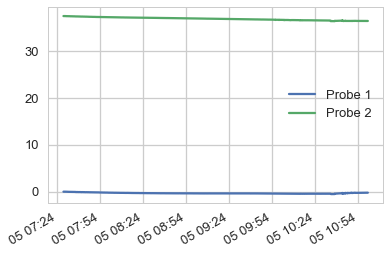

In [12]:
#########################
## Load processed data ##
#########################
dirPrint = dirPre + 'graphics'
dirProcessed = dirPre + 'proj/VertHarpExp2017Kloendeel/data/DTS_XT_VHSRE_processed'

os.chdir(dirProcessed)
ncFiles = ['VHRSE_chunk' + str(nFile) + '.nc' for nFile in np.arange(1, 10)]
ds = xr.open_mfdataset(ncFiles)
ds.attrs['locations'] = ds.attrs['locations'].split(';')

###################################################################################################################
# Extract out the XT times when it was managing the full experiment
expIndex = (ds.probe1Temperature < 100) & (ds.probe2Temperature < 100)\
            & (ds.probe2Temperature > 30) & (ds.probe1Temperature < 0)
ds = ds.isel(time=(expIndex == True))
ds = ds.sel(time=slice(pd.Timestamp(ds.time[0].values).to_pydatetime(), '2017-09-05 11:00'))

# Create a continuous time series
d1 = pd.Timestamp(ds.time[0].values).to_pydatetime()
d2 = pd.Timestamp(ds.time[-1].values).to_pydatetime()
fullTime = pd.date_range(start=d1, end=d2, freq='5s')
ds.reindex({'time': fullTime})

# Plot the resulting Dataset
fig, ax = plt.subplots(1, 1)
ax.plot(ds.time, ds.probe1Temperature, label='Probe 1')
ax.plot(ds.time, ds.probe2Temperature, label='Probe 2')
fig.autofmt_xdate()
ax.legend()

# Assign probes the correct name
ds['probeColdBath'] = ds.probe1Temperature
ds['probeWarmBath'] = ds.probe2Temperature

# Show the finalized dataset
print(ds)

- probe1Temperature is the cold bath
- probe2Temperature is the warm bath

Future versions of read/processing code will somehow need to do affiliate each probe temperature with the bath name for the below calibration to function.
***

In [15]:
# Location labels for quickly identifying sections
location = {

    ########################
    ## Near vertical harp ##
    ########################
    'vertHarpNear' : [47.3, 54.9],

    #######################
    ## Far vertical harp ##
    #######################
    # Segment 1, up and over ~ 326.2 to 329.75. 2m vertical separation,
    # tentatively assign 326.2 to 327.7 as the upward limb.
    'vertHarpFar': [326.2, 333.75],


    ######################
    ## Horizontal Array ##
    ######################
    'Horizontal - 86cm': [245, 294.5],
    'Horizontal - 84cm': [192.25, 242],
    'Horizontal - 60.5cm': [136, 185.5],
    'Horizontal - 56cm': [82.5, 132],

    #######################
    ## Temperature Baths ##
    #######################
    'warmBathNear': [29, 34],
    'coldBathNear': [17, 22],
    'warmBathFar': [346, 351],
    'coldBathFar': [357, 362],
    }

 Time step 2402 of 2403ime step 907 of 2403Time step 1666 of 2403Time step 1798 of 2403

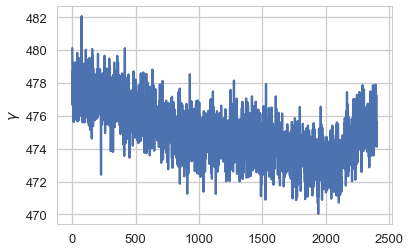

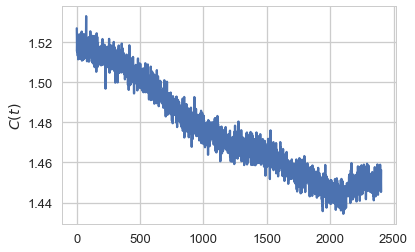

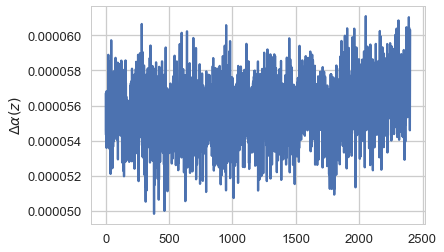

In [43]:
######################
## Matrix Inversion ##
######################

# Run the matrix inversion?
matrixInversionFlag = True

# Reference temperatures
refField1 = 'probeWarmBath' # Warm bath
refField2 = 'probeColdBath' # Cold bath
refField3 = 'probeWarmBath' # Warm bath
if matrixInversionFlag:
    refT1 = ds[refField1] + 273.15
    refT2 = ds[refField2] + 273.15
    refT3 = ds[refField3] + 273.15

    # Reference sections
    refLoc1 = 'warmBathNear'
    refLoc2 = 'coldBathNear'
    refLoc3 = 'warmBathFar'

    section1 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc1)
    section2 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc2)
    section3 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc3)

    ref_z1 = section1.LAF.mean(dim='location')
    ref_z2 = section2.LAF.mean(dim='location')
    ref_z3 = section3.LAF.mean(dim='location')

    # Amplitudes of stokes/anti-stokes
    stokesRatio1 = np.log(section1.Ps / section1.Pas).mean(dim='location')
    stokesRatio2 = np.log(section2.Ps / section2.Pas).mean(dim='location')
    stokesRatio3 = np.log(section3.Ps / section3.Pas).mean(dim='location')

    # Allocate the calibration variables
    gamma = np.ones(np.shape(ds.time.values)) * -9999.
    C = np.ones(np.shape(ds.time.values)) * -9999.
    delta_alpha = np.ones(np.shape(ds.time.values)) * -9999.

    # Within each time step solve for the calibration parameters
    for n, t in enumerate(ds.time):            
        print("\r", 'Time step ' + str(n) + ' of ' + str(np.size(ds.time.values)), end="")


        # A matrix
        A = [[1, -refT1.sel(time=t), refT1.sel(time=t) * ref_z1],
             [1, -refT2.sel(time=t), refT2.sel(time=t) * ref_z2],
             [1, -refT3.sel(time=t), refT3.sel(time=t) * ref_z3],
            ]

        # b matrix
        b = [[refT1.sel(time=t) * stokesRatio1.sel(time=t)],
             [refT2.sel(time=t) * stokesRatio2.sel(time=t)],
             [refT3.sel(time=t) * stokesRatio3.sel(time=t)],
            ]

        x = np.linalg.solve(A, b)

        gamma[n] = x[0]
        C[n] = x[1]
        delta_alpha[n] = x[2]
        
    ##############################
    ## Plot Calibration Results ##
    ##############################
    plt.plot(gamma)
    plt.gca().set_ylabel('$\gamma$')

    plt.figure()
    plt.plot(C)
    plt.gca().set_ylabel('$C(t)$')

    plt.figure()
    plt.plot(delta_alpha)
    plt.gca().set_ylabel(r'$\Delta  \alpha (z)$')


In [45]:
#############################
## Recalculate temperature ##
#############################
if matrixInversionFlag:
    manualTemp = np.ones(np.shape(ds.temp.values)) * -9999.

    for n, t in enumerate(ds.time):
        print("\r", 'Time step ' + str(n) + ' of ' + str(np.size(ds.time.values)), end="")
        manualTemp[n] = gamma[n] / (np.log(ds.Ps.sel(time=t) / ds.Pas.sel(time=t)) + C[n] - delta_alpha[n] * ds.LAF)

    ds['manualTemp'] = (('time', 'LAF'), manualTemp)

 Time step 0 of 2403

/anaconda/lib/python3.6/site-packages/dask/array/core.py:476: RuntimeWarning: overflow encountered in true_divide
  o = func(*args, **kwargs)
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


 Time step 1802 of 2403

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


 Time step 2402 of 2403

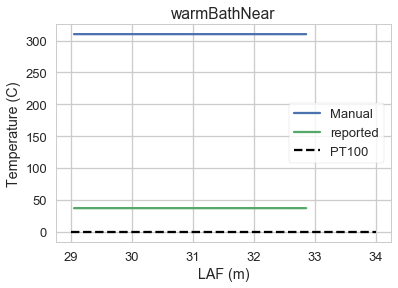

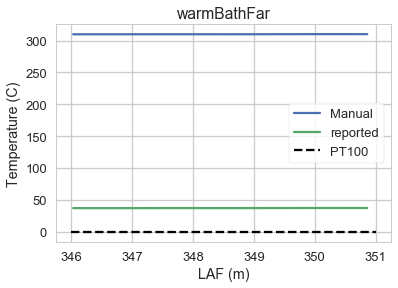

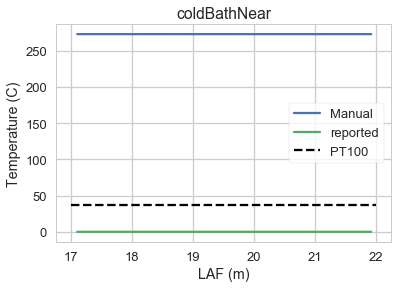

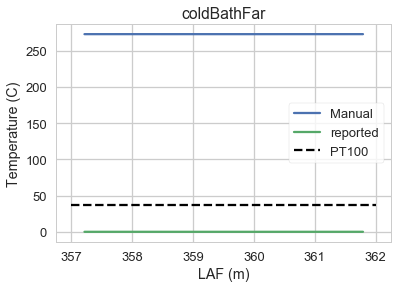

In [46]:
## Near warm bath
loc = 'warmBathNear'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot([location['warmBathNear'][0], location['warmBathNear'][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Far warm bath
loc = 'warmBathFar'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Near cold bath
loc = 'coldBathNear'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Far cold bath
loc = 'coldBathFar'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')


# Using $\overline{\Delta \alpha (t)}$ instead of $\Delta \alpha (t)$
From the calibration routine, the calibrated parameters are shown below. These are copy-pasted results (not dynamically created by running the above code with the flag set to True.



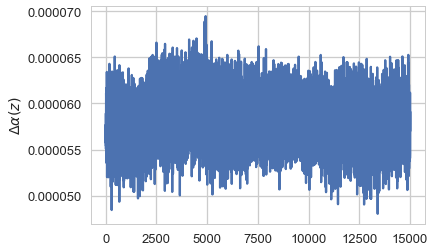

In [19]:
Image(filename='/Users/karllapo/Desktop/proj/VertHarpExp2017Kloendeel/python/DTS/MatrixInversion_DeltaAlpha_t.png')

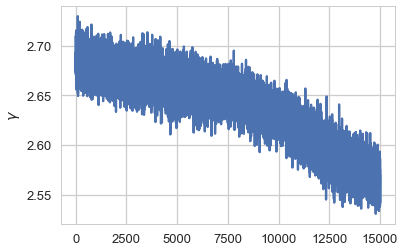

In [20]:
Image(filename='/Users/karllapo/Desktop/proj/VertHarpExp2017Kloendeel/python/DTS/MatrixInversion_Gamma.png')

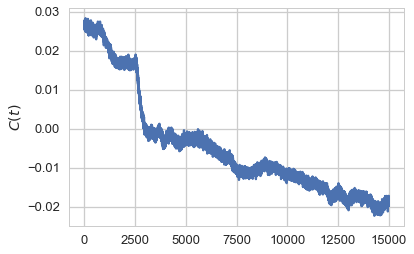

In [21]:
Image(filename='/Users/karllapo/Desktop/proj/VertHarpExp2017Kloendeel/python/DTS/MatrixInvesion_C_t.png')

<mark>- C(t) should not cross zero, that is weird.</mark>  
<mark>- $\gamma$ is too low</mark>  
<mark>- $\alpha$(t) is super noisy, suggests we should instead use the temporal average rather than letting the quantity jump each time step.</mark>


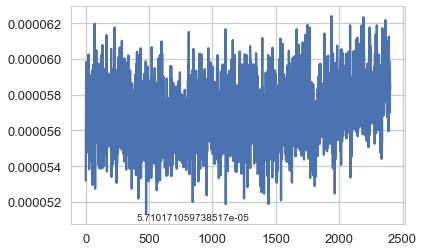

In [22]:
## Solve for delta alpha linearly through a single reference section
# from sklearn import datasets, linear_model
# from sklearn.metrics import mean_squared_error, r2_score

# # Create linear regression object
# regr = linear_model.LinearRegression()

# # Train the model using the training sets
# regr.fit(diabetes_X_train, diabetes_y_train)

# # Make predictions using the testing set
# diabetes_y_pred = regr.predict(diabetes_X_test)

# # The coefficients
# print('Coefficients: \n', regr.coef_)
# # The mean squared error
# print("Mean squared error: %.2f"
#       % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# # Explained variance score: 1 is perfect prediction
# print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))


## Solve for delta alpha by interpolating between two reference baths
refFieldWarm = 'probe1Temperature' # Warm bath
refFieldCold = 'probe2Temperature' # Cold bath

refTWarm = ds[refField1]
refTCold = ds[refField2]

# Reference sections
refLoc1 = 'coldBathNear'
refLoc2 = 'coldBathFar'

section1 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc1)
section2 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc2)

ref_z1 = section1.LAF.mean(dim='location')
ref_z2 = section2.LAF.mean(dim='location')

# Amplitudes of stokes/anti-stokes
stokesRatio1 = np.log(section1.Ps / section1.Pas).mean(dim='location')
stokesRatio2 = np.log(section2.Ps / section2.Pas).mean(dim='location')

deltaAlpha = (stokesRatio2 - stokesRatio1) / (ref_z2 - ref_z1)
deltaAlphaMean = deltaAlpha.mean(dim='time').values
plt.plot(deltaAlpha)
plt.text(400, 0.000051, str(deltaAlpha.mean(dim='time').values))

Same order of magnitude, qualitatively similar shape to the matrix inversion parameter value.

_*NOTE*_ There is a sign error in equation 5 of Hausner 2011.

/anaconda/lib/python3.6/site-packages/dask/array/core.py:476: RuntimeWarning: divide by zero encountered in true_divide
  o = func(*args, **kwargs)


 Time step 2402 of 2403Time step 1010 of 2403Time step 1590 of 2403

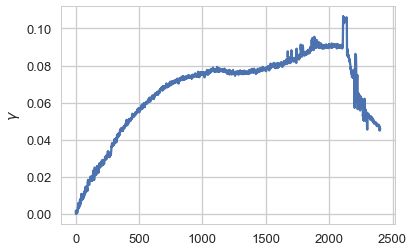

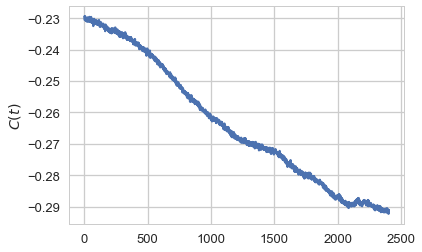

In [23]:
# Now to solve for gamma and C directly
# Run the matrix inversion?
matrixInversionFlag = True

# Reference temperatures
refField1 = 'probe1Temperature' # Warm bath
refField2 = 'probe2Temperature' # Cold bath
refT1 = ds[refField1]
refT2 = ds[refField2]

if matrixInversionFlag:
    # Reference sections
    refLoc1 = 'warmBathNear'
    refLoc2 = 'coldBathFar'

    section1 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc1)
    section2 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc2)

    ref_z1 = section1.LAF.mean(dim='location')
    ref_z2 = section2.LAF.mean(dim='location')

    # Amplitudes of stokes/anti-stokes
    stokesRatio1 = np.log(section1.Ps / section1.Pas).mean(dim='location')
    stokesRatio2 = np.log(section2.Ps / section2.Pas).mean(dim='location')

    # Allocate the calibration variables
    gamma = np.ones(np.shape(ds.time.values)) * -9999.
    C = np.ones(np.shape(ds.time.values)) * -9999.

    # Within each time step solve for the calibration parameters
    for n, t in enumerate(ds.time):
        print("\r", 'Time step ' + str(n) + ' of ' + str(np.size(ds.time.values)), end="")


        # A matrix
        A = [[1, -refT1.sel(time=t).values],
             [1, -refT2.sel(time=t).values]
            ]

        # b matrix
        b = [[refT1.sel(time=t).values * stokesRatio1.sel(time=t).values
              - deltaAlphaMean * ref_z1.values * refT1.sel(time=t).values],
             [refT2.sel(time=t).values * stokesRatio2.sel(time=t).values
              - deltaAlphaMean * ref_z2.values * refT2.sel(time=t).values],
            ]

        x = np.linalg.solve(A, b)

        gamma[n] = x[0]
        C[n] = x[1]
        
    ##############################
    ## Plot Calibration Results ##
    ##############################
    plt.plot(gamma)
    plt.gca().set_ylabel('$\gamma$')

    plt.figure()
    plt.plot(C)
    plt.gca().set_ylabel('$C(t)$')

This result is, as far as I can tell, identical to the original matrix inversion. Clearly there is a deeper issue to investigate here.

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(section1.time, np.log(section1.Ps / section1.Pas).mean(dim='location'))
ax.plot(section1.time, np.log(section2.Ps / section2.Pas).mean(dim='location'))

ax.annotate('What happens at this time?', xy=(pd.datetime(2017, 9, 4, 18, 45, 0), 0.05),
            xytext=(pd.datetime(2017, 9, 4, 20, 0, 0), 0.05), fontsize=14,
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax.plot([pd.datetime(2017, 9, 4, 18, 30, 0), pd.datetime(2017, 9, 4, 18, 30, 0)], [0.03, 0.3], 'r--')
ax.plot([pd.datetime(2017, 9, 4, 19, 30, 0), pd.datetime(2017, 9, 4, 19, 30, 0)], [0.03, 0.3], 'b--')
ax.set_ylabel('ln(Ps/Pas)')

The mean log(Ps/Pas) for the near warm bath (blue) and the cold bath (green). Both exhibit the jump around 1900 which is associated with calibrated C(t) crossing zero.

- Spent some time checking the gunk in the xml files to see if there is an obvious reason for the jump -- nothing _jumped_ out at at me
- I appear to be missing an hours worth of xml data from the Ultima (1730-1830)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

# ax = axes[0]
t = pd.datetime(2017, 9, 4, 18, 30, 0)
ds_at_time = ds.sel(time=t)
ax.plot(ds_at_time.LAF, np.log(ds_at_time.Ps / ds_at_time.Pas), 'r', label='time 1')

t = pd.datetime(2017, 9, 4, 19, 30, 0)
ds_at_time = ds.sel(time=t)
ax.plot(ds_at_time.LAF, np.log(ds_at_time.Ps / ds_at_time.Pas), 'b', label='time 2')

ax.set_ylim(0.01, 0.3)
ax.set_xlim(0, 380)
ax.legend()

# Image of data
fig, ax = plt.subplots(1, 1, figsize=(15,8))
temp_ds = ds.sel(time= slice(pd.datetime(2017, 9, 4, 18, 30, 0), pd.datetime(2017, 9, 4, 19, 30, 0)))
H = np.ma.masked_array(np.log(temp_ds.Ps/temp_ds.Pas), np.isnan(np.log(temp_ds.Ps/temp_ds.Pas)))
t = temp_ds.time.values
length = temp_ds.LAF.values
X, Y = np.meshgrid(t, length)

im = ax.pcolormesh(X.T, Y.T, H, cmap=cm.Blues, vmin=0.01, vmax=0.3)
ax.set_ylim(0, 380)


# 5) Results

## Spatial evaluation
This is the calibrated temperature using the reference sections from the near and far warm bath and the far cold bath. Results are averaged in time and reported spatially.

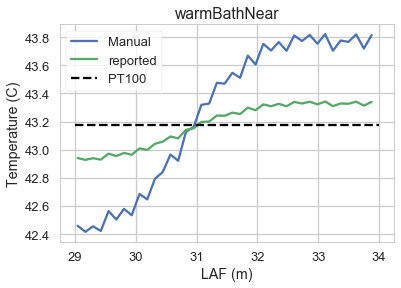

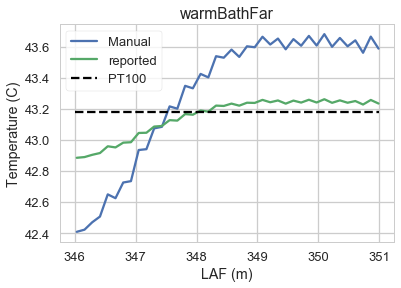

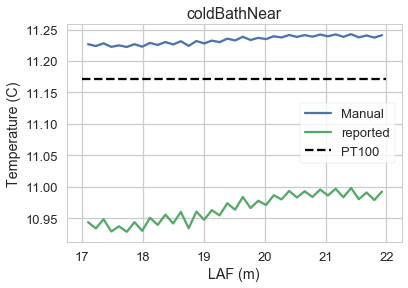

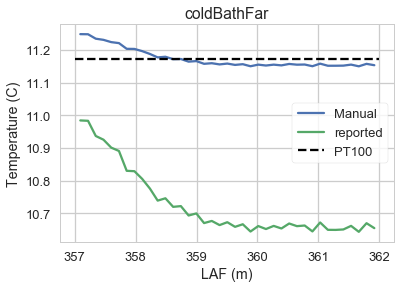

In [16]:
## Near warm bath
loc = 'warmBathNear'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot([location['warmBathNear'][0], location['warmBathNear'][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Far warm bath
loc = 'warmBathFar'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Near cold bath
loc = 'coldBathNear'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Far cold bath
loc = 'coldBathFar'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')


<mark>- There appears to be a really bad saw-tooth pattern. This needs further lab testing, since it is larger than sawtooth artefacts that John has encountered in other experiments.</mark>


## Temporal evaluation

Same as before except the results are spatially and reported as a function of time.

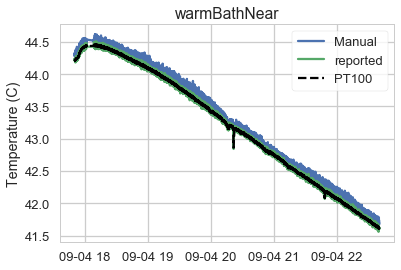

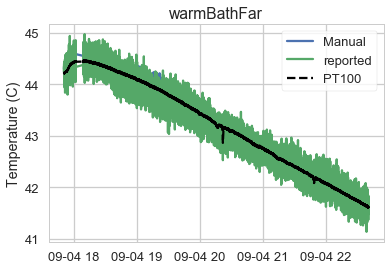

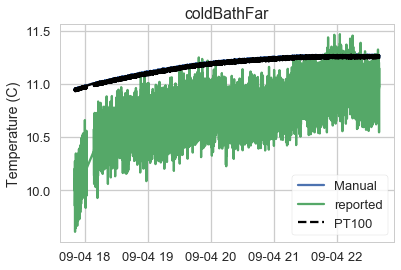

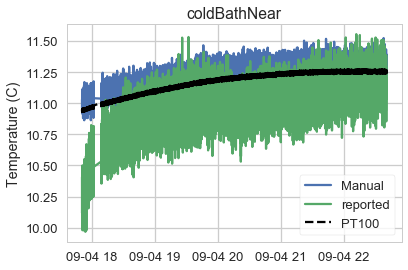

In [17]:
## Near warm bath
loc = 'warmBathNear'
plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Far warm bath
loc = 'warmBathFar'
plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Far cold bath
loc = 'coldBathFar'

plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Near cold bath
loc = 'coldBathNear'

plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

The calibrated temperatures absolutely nail the far and near warm baths, but have issues with the near cold bath (albeit with a better result than the instrument reported temperatures) but worse results for the near warm bath. This combination of reference sections yields the best results.

# 6) Re-calibrate using different reference sections

Calibration sections:
    - warm bath far
    - cold bath far
    - cold bath near

Validation section:
    - warm bath near

In [18]:
# Reference temperatures
refField1 = 'probe2Temperature' # Cold bath
refField2 = 'probe1Temperature' # Warm bath
refField3 = 'probe2Temperature' # Cold bath

refT1 = ds[refField1]
refT2 = ds[refField2]
refT3 = ds[refField3]

# Reference sections
refLoc1 = 'coldBathFar'
refLoc2 = 'warmBathFar'
refLoc3 = 'coldBathNear'

section1 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc1)
section2 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc2)
section3 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc3)

ref_z1 = section1.LAF.mean(dim='location')
ref_z2 = section2.LAF.mean(dim='location')
ref_z3 = section3.LAF.mean(dim='location')

# Amplitudes of stokes/anti-stokes
stokesRatio1 = np.log(section1.Ps / section1.Pas).mean(dim='location')
stokesRatio2 = np.log(section2.Ps / section2.Pas).mean(dim='location')
stokesRatio3 = np.log(section3.Ps / section3.Pas).mean(dim='location')

# Allocate the calibration variables
gamma = np.ones(np.shape(ds.time.values)) * -9999.
C = np.ones(np.shape(ds.time.values)) * -9999.
delta_alpha = np.ones(np.shape(ds.time.values)) * -9999.

# Within each time step solve for the calibration parameters
for n, t in enumerate(ds.time):
    print("\r", 'Time step ' + str(n) + ' of ' + str(np.size(ds.time.values)), end="")

    
    # A matrix
    A = [[1, -refT1.sel(time=t), refT1.sel(time=t) * ref_z1],
         [1, -refT2.sel(time=t), refT2.sel(time=t) * ref_z2],
         [1, -refT3.sel(time=t), refT3.sel(time=t) * ref_z3],
        ]

    # b matrix
    b = [[refT1.sel(time=t) * stokesRatio1.sel(time=t)],
         [refT2.sel(time=t) * stokesRatio2.sel(time=t)],
         [refT3.sel(time=t) * stokesRatio3.sel(time=t)],
        ]

    x = np.linalg.solve(A, b)
    
    gamma[n] = x[0]
    C[n] = x[1]
    delta_alpha[n] = x[2]
    
#############################
## Recalculate temperature ##
#############################
manualTemp = np.ones(np.shape(ds.temp.values)) * -9999.

for n, t in enumerate(ds.time):
    print("\r", 'Time step ' + str(n) + ' of ' + str(np.size(ds.time.values)), end="")
    manualTemp[n] = gamma[n] / (np.log(ds.Ps.sel(time=t) / ds.Pas.sel(time=t)) + C[n] - delta_alpha[n] * ds.LAF)
    
ds['manualTemp'] = (('time', 'LAF'), manualTemp)

 Time step 3 of 150005000ime step 4905 of 15000Time step 12952 of 15000Time step 13568 of 15000

/anaconda/lib/python3.6/site-packages/dask/array/core.py:476: RuntimeWarning: overflow encountered in true_divide
  o = func(*args, **kwargs)
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in log


 Time step 14999 of 15000

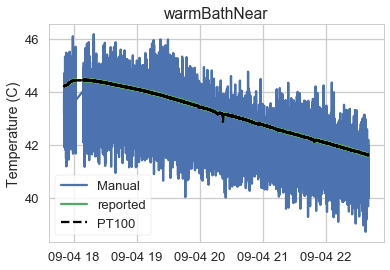

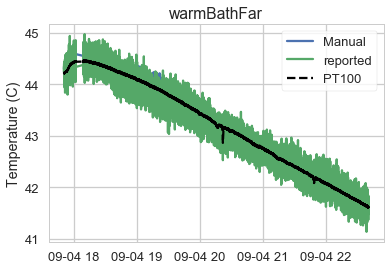

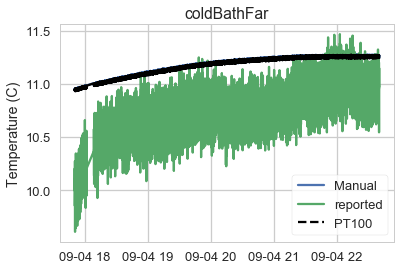

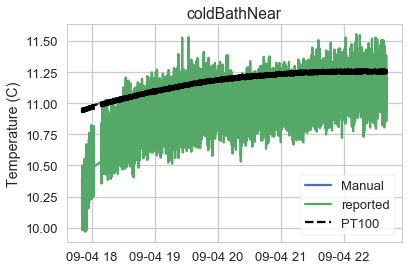

In [19]:
## Near warm bath
loc = 'warmBathNear'
plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Far warm bath
loc = 'warmBathFar'
plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Far cold bath
loc = 'coldBathFar'

plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Near cold bath
loc = 'coldBathNear'

plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

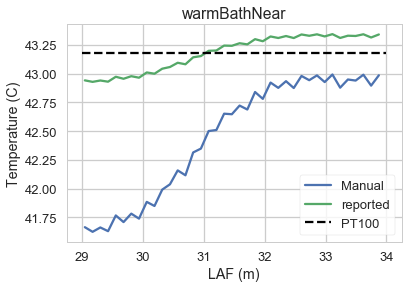

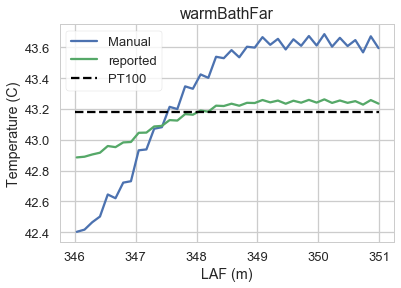

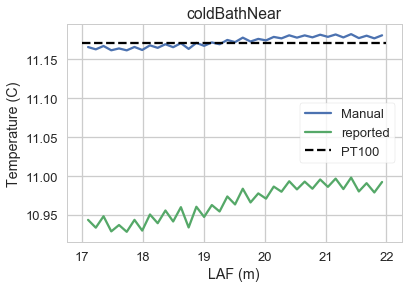

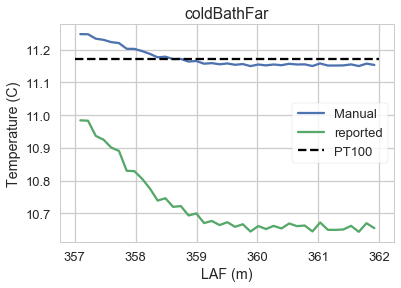

In [20]:
## Near warm bath
loc = 'warmBathNear'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot([location['warmBathNear'][0], location['warmBathNear'][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Far warm bath
loc = 'warmBathFar'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Near cold bath
loc = 'coldBathNear'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Far cold bath
loc = 'coldBathFar'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')


## Calibration using $\overline{\Delta \alpha (t)}$ (constant mean value)

In [ ]:
# Reference temperatures
refField1 = 'probe2Temperature' # Cold bath
refField2 = 'probe1Temperature' # Warm bath
refField3 = 'probe2Temperature' # Cold bath

refT1 = ds[refField1]
refT2 = ds[refField2]
refT3 = ds[refField3]

# Reference sections
refLoc1 = 'coldBathFar'
refLoc2 = 'warmBathFar'
refLoc3 = 'coldBathNear'

section1 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc1)
section2 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc2)
section3 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc3)

ref_z1 = section1.LAF.mean(dim='location')
ref_z2 = section2.LAF.mean(dim='location')
ref_z3 = section3.LAF.mean(dim='location')

# Amplitudes of stokes/anti-stokes
stokesRatio1 = np.log(section1.Ps / section1.Pas).mean(dim='location')
stokesRatio2 = np.log(section2.Ps / section2.Pas).mean(dim='location')
stokesRatio3 = np.log(section3.Ps / section3.Pas).mean(dim='location')

# Allocate the calibration variables
gamma = np.ones(np.shape(ds.time.values)) * -9999.
C = np.ones(np.shape(ds.time.values)) * -9999.
delta_alpha = np.ones(np.shape(ds.time.values)) * -9999.

# Within each time step solve for the calibration parameters
for n, t in enumerate(ds.time):
    print("\r", 'Time step ' + str(n) + ' of ' + str(np.size(ds.time.values)), end="")

    
    # A matrix
    A = [[1, -refT1.sel(time=t), refT1.sel(time=t) * ref_z1],
         [1, -refT2.sel(time=t), refT2.sel(time=t) * ref_z2],
         [1, -refT3.sel(time=t), refT3.sel(time=t) * ref_z3],
        ]

    # b matrix
    b = [[refT1.sel(time=t) * stokesRatio1.sel(time=t)],
         [refT2.sel(time=t) * stokesRatio2.sel(time=t)],
         [refT3.sel(time=t) * stokesRatio3.sel(time=t)],
        ]

    x = np.linalg.solve(A, b)
    
    gamma[n] = x[0]
    C[n] = x[1]
    delta_alpha[n] = x[2]
    
#############################
## Recalculate temperature ##
#############################
manualTemp = np.ones(np.shape(ds.temp.values)) * -9999.

for n, t in enumerate(ds.time):
    print("\r", 'Time step ' + str(n) + ' of ' + str(np.size(ds.time.values)), end="")
    manualTemp[n] = gamma[n] / (np.log(ds.Ps.sel(time=t) / ds.Pas.sel(time=t)) + C[n] - delta_alpha[n] * ds.LAF)
    
ds['manualTemp'] = (('time', 'LAF'), manualTemp)

## Evaluations for after the clear offsets and spatial trends are accounted for

This is just a series of graphs showing the RMSE and bias for each calibration. I'm ignoring these until the head-scratcher issue in calibration is resolved.

In [39]:
# hide_me = ''
# HTML('''<script>
#   $(document).ready(function(){
#     $('div.prompt').hide();
#     $('div.back-to-top').hide();
#     $('nav#menubar').hide();
#     $('.breadcrumb').hide();
#     $('.hidden-print').hide();
#     $('div.output_stderr').hide();
#   });
# </script>''')